##Problem Statement

Our company, Best Braces USA, expends a great deal of capital each year on advertising. Our top three products (Knee Braces, Ankle Braces, and Shoulder Braces) account for 75% of that spend. As the various channels (TV, Radio, Social Media, Point of Sale, etc) to engage with different age groups become more diverse, we want to maximize our ad dollar efficiency by right-channeling those ads for the biggest consumers of each product. That is to say, for example, if we can find that 18-25 year olds have the biggest need for Knee Braces, then we may want to spend most of our Knee Brace ad dollars in the social media areas. The company as a whole, and our shareholders, will benefit from this more focused advertising. In particular, this will clearly be powerful information for our sales and advertising departments.


##Hypothesis

We will start with the Null Hypothesis as “There is no statistical difference in the mean age of males who suffer sprains/strains to the knee, ankle, or shoulder”. The Alternative Hypothesis then becomes “There is a statistical difference in the mean age of males who suffer sprains/strains to the knee, ankle, or shoulder”

##Data

Every year, the U.S. Consumer Product Safety Commission tracks emergency rooms visits to approximately 100 hospitals. For this project, we will focus on the 2023 data. This data contains, among other things, the age and sex of the patient, what their final diagnosis was, and what was the part of the body that was injured. We will take a subset of this data: Males with a diagnosis of Sprain/Strain to the Knee, Ankle, or Shoulder. This data is of particular interest to us since our braces are specifically designed to 1) prevent sprains/strains as well as 2) provide rehab support for those having suffered such an injury

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

#Loading the data
#NOTE: This is a large dataset and will take several minutes to load
df=pd.read_excel("https://www.cpsc.gov/cgibin/NEISSQuery/Data/Archived%20Data/2023/neiss2023.xlsx", usecols='A,C,D,H,I')

In order to limit variables in the data, and as they represents the primary portion of our customers, we will limit the data to men between the ages of 15 and 65.

In [12]:
df_refined=df[df["Gender"]==1] #Filter the dataset to Men only
df_refined=df_refined[df_refined["Diagnosis"]==64] #Filter the dataset to patients with a sprain/strain diagnosis only
df_refined=df_refined[(df_refined["Age"]>=15) & (df_refined["Age"]<=65)] #Filter the dataframe to patients with an Age between 15 and 65

print(df_refined.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10172 entries, 17 to 338258
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   CPSC_Case_Number  10172 non-null  int64
 1   Age               10172 non-null  int64
 2   Gender            10172 non-null  int64
 3   Body_Part         10172 non-null  int64
 4   Diagnosis         10172 non-null  int64
dtypes: int64(5)
memory usage: 476.8 KB
None


##Method

The dataset will be divided into the three effected body parts, and then we will use histograms and statistical features (e.g. skewness and kurtosis) to determine normality (or not). Based on results there, we will choose between pairwise t-tests, a one-way ANOVA test, and/or a Kruskal-Wallis test to determine if the Null Hypothesis can be rejected or not. We will report using the 95% confidence interval and thus a p-value of .05.

We begin with observing the histograms by Body Part.

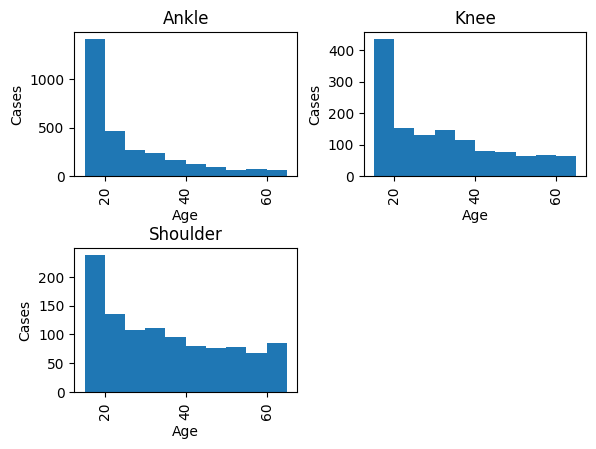

In [13]:
df_refined=df_refined[df_refined["Body_Part"].isin([30,35,37])] #Remove all but injuries to the Shoulder, Knee, or Ankle
df_refined.loc[:, "Body_Part"] = df_refined["Body_Part"].replace({30: "Shoulder", 35: "Knee", 37: "Ankle"}) #Use the body part name vs code for clarity

axes = df_refined['Age'].hist(by=df_refined['Body_Part']) #Create histograms
#Set the x and y axis labels for each subplot
for ax in axes.flatten():
    ax.set_xlabel('Age')
    ax.set_ylabel('Cases')
plt.show()

Based on visual inspection of the histograms, these do not appear to be normal. We will now create individual dataframes for each body part and then use inferential statistics values to further assess normality.

In [14]:
df_shoulder=df_refined[df_refined["Body_Part"]=="Shoulder"] #create a dataframe for shoulder injuries
df_knee=df_refined[df_refined["Body_Part"]=="Knee"] #create a dataframe for knee injuries
df_ankle=df_refined[df_refined["Body_Part"]=="Ankle"] #create a dataframe for ankle injuries

shoulder=stats.describe(df_shoulder['Age']) #Calcluate and report the Shoulder stats
print(f"The Shoulder dataset has a length of {len(df_shoulder)} records and a mean Age of {round(shoulder.mean,2)}. The skewness is {round(shoulder.skewness,2)} with kurtosis of {round(shoulder.kurtosis,2)}")
knee=stats.describe(df_knee['Age']) #Calcluate and report the Knee stats
print(f"The Knee dataset has a length of {len(df_knee)} records and a mean Age of {round(knee.mean,2)}. The skewness is {round(knee.skewness,2)} with a kurtosis of {round(knee.kurtosis,2)}")
ankle=stats.describe(df_ankle['Age']) #Calcluate and report the Ankle stats
print(f"The Ankle dataset has a length of {len(df_ankle)} records and a mean Age of {round(ankle.mean,2)}. The skewness is {round(ankle.skewness,2)} with a kurtosis of {round(ankle.kurtosis,2)}")

The Shoulder dataset has a length of 1076 records and a mean Age of 34.53. The skewness is 0.42 with kurtosis of -1.08
The Knee dataset has a length of 1330 records and a mean Age of 30.94. The skewness is 0.71 with a kurtosis of -0.66
The Ankle dataset has a length of 2988 records and a mean Age of 25.44. The skewness is 1.41 with a kurtosis of 1.19


Based on the range of skewness and kurtosis values, these datasets cannot be considered normal. The data is largely right-skewed and too flat.

Given this, we will proceed using a Kruskal-Wallis test.

In [15]:
stats.kruskal(df_shoulder['Age'], df_knee['Age'], df_ankle['Age'])

KruskalResult(statistic=373.3961680284663, pvalue=8.280419333676079e-82)

The resulting p-value is <.001 and we can therefore conclude that there <B>is a statistically significant difference</B> between the groups being compared in the Kruskal-Wallis test. The null hypothesis, therefore, can be rejected.

Let's further see if we can compare pairwise datasets to determine if there is only one which stands out or if all have discrete ranges. As this data is non-normal, we will conduct a Dunn's test.

In [8]:
!pip install scikit_posthocs

In [16]:
import scikit_posthocs as sp

df_refined = pd.concat([df_shoulder.assign(Group='df_shoulder'), df_knee.assign(Group='df_knee'), df_ankle.assign(Group='df_ankle')])
sp.posthoc_dunn(df_refined, val_col='Age', group_col='Group', p_adjust='bonferroni')

,df_ankle,df_knee,df_shoulder
df_ankle,1.000000e+00,3.697683e-32,6.949900e-72
df_knee,3.697683e-32,1.000000e+00,4.755053e-09
df_shoulder,6.949900e-72,4.755053e-09,1.000000e+00


Using the Dunn's Test for pairwise comparison, we can additionally see a low p-value (<.001) for each pair. This indicates that each dataset is statistically different from one another when considering Age.

Finally, we would like to see what age ranges define the 95% confidence interval for each set - Shoulder, Knee, and Ankle - so that advertising could be targeted at these.

Again, due to the non-normality of the data, we will use a bootstrap method with random sampling (1000 samples for Body Part) to calculate the ranges.

In [17]:
def calc_ci(df, num_samples=1000, alpha=0.05):
    np.random.seed(0) #seed the randomization
    n = len(df) #set n to the size of the dataset
    median_values = [] #initialize list to hold median samples

    #perform bootstrap sampling
    for x in range(num_samples): #for 1000 loops
        sample = np.random.choice(df['Age'], size=n, replace=True) #select n random samples (with replacement)
        median_values.append(np.median(sample)) #calculate the median and add it to the list of medians

    #calculate confidence interval (ci of 95% means an alpha of .05)
    lower = int((alpha / 2) * num_samples) #calc the lower limit
    upper = int((1 - alpha / 2) * num_samples) #calc the upper limit
    median_values_sorted = np.sort(median_values) #sort the list of medians gathered in the preceeding for loop
    lower_ci = median_values_sorted[lower] #select the lower ci value
    upper_ci = median_values_sorted[upper] #select the upper ci value

    return np.median(df['Age']), lower_ci, upper_ci #return the original df's median and the calculated lower and upper ci values

#calc the ci values for each dataset
median_knee, lower_knee, upper_knee = calc_ci(df_knee)
median_shoulder, lower_shoulder, upper_shoulder = calc_ci(df_shoulder)
median_ankle, lower_ankle, upper_ankle = calc_ci(df_ankle)

#print out the final values
print(f"Knee dataset: Median = {median_knee}, 95% CI = ({lower_knee}, {upper_knee})")
print(f"Shoulder dataset: Median = {median_shoulder}, 95% CI = ({lower_shoulder}, {upper_shoulder})")
print(f"Ankle dataset: Median = {median_ankle}, 95% CI = ({lower_ankle}, {upper_ankle})")

Knee dataset: Median = 27.5, 95% CI = (26.0, 29.0)
Shoulder dataset: Median = 32.0, 95% CI = (30.5, 33.0)
Ankle dataset: Median = 20.0, 95% CI = (20.0, 20.5)


##Results

Using a 95% confidence interval, we have been able to conclude that there is a statistically significant difference in the median age for males (aged 15-65) who suffer Knee, Shoulder, and Ankle strains/sprains in the available data.

Using the median and confidence interval values, we can conclude that advertising for our braces should be as below:


*   Knee Braces should be targeted to men in their mid to late 20s
*   Shoulder Braces should be targeted to men in their early to mid 30s
*   Ankle Braces should be targeted to men in their early 20s





##What's Next?

Given that we have evidenced a significant difference using Age and for men within a target demographic, we may wish to expand this:


*   Complete the same exercise for females
*   Research other parts of the body to see if there are stand-outs which we may wish to explore (e.g. R&D into braces for new body parts)
*   Explore trends over multiple years of the available data. If we see, for example, that the median age for Ankle injuries is trending downwards then we may wish to explore partnerships with High School sports programs.

This dataset is rich. Given time to explore, we believe we can continue to extract useful insights.





